In [38]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.model_selection import train_test_split
%matplotlib inline

In [ ]:
plt.figure(figsize=(8,5))

# how many time steps/data pts are in one batch of data
seq_length = 20

# generate evenly spaced data pts
time_steps = np.linspace(0, np.pi, seq_length + 1)
data = np.sin(time_steps)
data.resize((seq_length + 1, 1)) # size becomes (seq_length+1, 1), adds an input_size dimension

x = data[:-1] # all but the last piece of data
y = data[1:] # all but the first

# display the data
plt.plot(time_steps[1:], x, 'r.', label='input, x') # x
plt.plot(time_steps[1:], y, 'b.', label='target, y') # y

plt.legend(loc='best')
plt.show()

In [32]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        
        self.hidden_dim=hidden_dim

        # define an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        
        # last, fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)
        
        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden)
        # shape output to be (batch_size*seq_length, hidden_dim)
        r_out = r_out.view(-1, self.hidden_dim)  
        
        # get final output 
        output = self.fc(r_out)
        
        return output, hidden

In [33]:
# test that dimensions are as expected
test_rnn = RNN(input_size=1, output_size=1, hidden_dim=10, n_layers=2)


# generate evenly spaced, test data pts
time_steps = np.linspace(0, np.pi, seq_length)
data = np.sin(time_steps)
data.resize((seq_length, 1))

test_input = torch.Tensor(data).unsqueeze(0) # give it a batch_size of 1 as first dimension
print('Input size: ', test_input.size())

# test out rnn sizes
test_out, test_h = test_rnn(test_input, None)
print('Output size: ', test_out.size())
print('Hidden state size: ', test_h.size())

In [35]:
input_size=1 
output_size=1
hidden_dim=32
n_layers=1

# instantiate an RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

In [25]:
# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01) 

In [26]:
# train the RNN
def train(rnn, n_steps, print_every):
    
    # initialize the hidden state
    hidden = None      
    
    for batch_i, step in enumerate(range(n_steps)):
        # defining the training data 
        time_steps = np.linspace(step * np.pi, (step+1)*np.pi, seq_length + 1)
        data = np.sin(time_steps)
        data.resize((seq_length + 1, 1)) # input_size=1

        x = data[:-1]
        y = data[1:]
        
        # convert data into Tensors
        x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
        y_tensor = torch.Tensor(y)

        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data

        # calculate the loss
        loss = criterion(prediction, y_tensor)
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
        optimizer.step()

        # display loss and predictions
        if batch_i%print_every == 0:        
            print('Loss: ', loss.item())
            plt.plot(time_steps[1:], x, 'r.') # input
            plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.') # predictions
            plt.show()
    
    return rnn

In [ ]:
# train the rnn and monitor results
n_steps = 75
print_every = 5

trained_rnn = train(rnn, n_steps, print_every)

In [10]:
# Задача
# 1. Сгенерируйте набор данных для предсказания временных последовательностей. Выполните тренировку RNN
# 2. Модифицируйте сеть, используя в качестве рекуррентного слоя LSTM слой библиотеки pytorch.
# https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

# 3. решите задачу набора данных лекции 7.

In [104]:
# 1. Сгенерируйте набор данных для предсказания временных последовательностей. Выполните тренировку 
# Параметры временного ряда
from torch.utils.data import Dataset, DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, index):
        x = self.data[index:index + self.seq_length]
        y = self.data[index + self.seq_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [105]:
seq_length = 20
n_samples = 1000
x = np.linspace(0, 100, n_samples)
data = np.sin(x) + 0.5 * np.random.normal(size=len(x))

train_size = int(0.8 * len(data))
train_data = data[:train_size]
test_data = data[train_size:]

train_dataset = TimeSeriesDataset(train_data, seq_length)
test_dataset = TimeSeriesDataset(test_data, seq_length)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [106]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)  # Инициализация скрытого состояния
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  # Используем только последний выход
        return out

In [107]:
def train_model(model, dataloader, epochs=10, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        for batch_x, batch_y in dataloader:
            batch_x = batch_x.view(-1, seq_length, input_size)
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y.unsqueeze(1))
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

In [108]:
input_size = 1
hidden_size = 50
output_size = 1
rnn_model = RNN(input_size, hidden_size, output_size)
train_model(rnn_model, train_dataloader, epochs=20)


Epoch [1/20], Loss: 0.3919
Epoch [2/20], Loss: 0.2951
Epoch [3/20], Loss: 0.3305
Epoch [4/20], Loss: 0.3717
Epoch [5/20], Loss: 0.2739
Epoch [6/20], Loss: 0.2788
Epoch [7/20], Loss: 0.1418
Epoch [8/20], Loss: 0.2920
Epoch [9/20], Loss: 0.4486
Epoch [10/20], Loss: 0.1041
Epoch [11/20], Loss: 0.5858
Epoch [12/20], Loss: 0.2361
Epoch [13/20], Loss: 0.2282
Epoch [14/20], Loss: 0.2375
Epoch [15/20], Loss: 0.1541
Epoch [16/20], Loss: 0.3745
Epoch [17/20], Loss: 0.3897
Epoch [18/20], Loss: 0.2215
Epoch [19/20], Loss: 0.2269
Epoch [20/20], Loss: 0.1901


In [109]:
# Оценка модели
model = rnn_model
model.eval()
predictions = []
actual = []

with torch.no_grad():
    for x, y in test_dataloader:
        x = x.view(1, seq_length, input_size)
        pred = model(x).item()
        predictions.append(pred)
        actual.append(y.item())

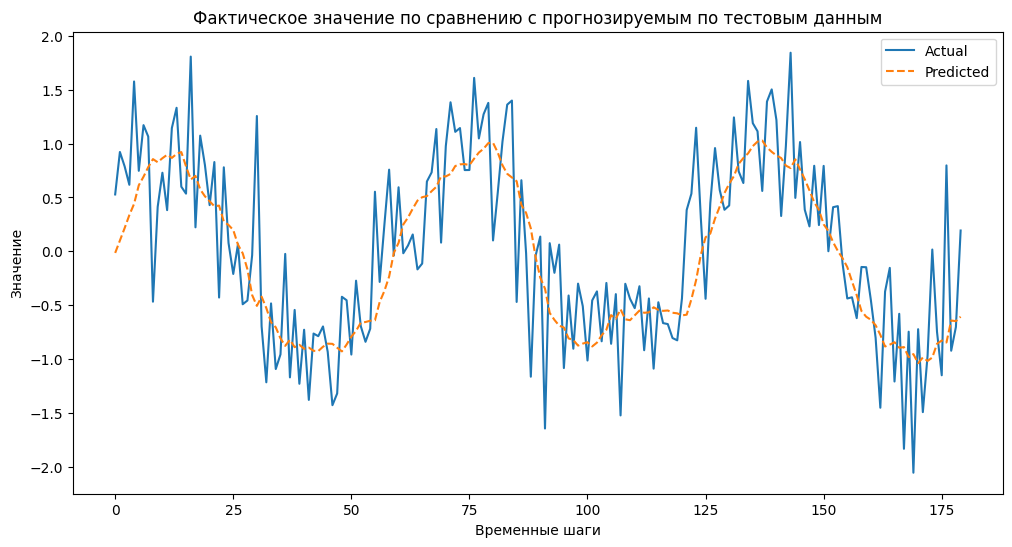

In [119]:
plt.figure(figsize=(12, 6))
plt.plot(actual, label="Actual", linestyle='-')
plt.plot(predictions, label="Predicted", linestyle='--')
plt.legend()
plt.xlabel("Временные шаги")
plt.ylabel("Значение")
plt.title("Фактическое значение по сравнению с прогнозируемым по тестовым данным")
plt.show()

In [111]:
# 2. Модифицируйте сеть, используя в качестве рекуррентного слоя LSTM слой библиотеки pytorch.
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)  
        c0 = torch.zeros(1, x.size(0), self.hidden_size)  
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  
        return out

In [112]:
lstm_model = LSTM(input_size, hidden_size, output_size)
train_model(lstm_model, train_dataloader, epochs=20)

Epoch [1/20], Loss: 0.6071
Epoch [2/20], Loss: 0.2945
Epoch [3/20], Loss: 0.3950
Epoch [4/20], Loss: 0.1563
Epoch [5/20], Loss: 0.5104
Epoch [6/20], Loss: 0.1524
Epoch [7/20], Loss: 0.4504
Epoch [8/20], Loss: 0.2427
Epoch [9/20], Loss: 0.2213
Epoch [10/20], Loss: 0.3661
Epoch [11/20], Loss: 0.5183
Epoch [12/20], Loss: 0.3112
Epoch [13/20], Loss: 0.2486
Epoch [14/20], Loss: 0.1038
Epoch [15/20], Loss: 0.4506
Epoch [16/20], Loss: 0.1435
Epoch [17/20], Loss: 0.5438
Epoch [18/20], Loss: 0.1296
Epoch [19/20], Loss: 0.2703
Epoch [20/20], Loss: 0.2520


In [113]:
model = lstm_model
model.eval()
predictions = []
actual = []

with torch.no_grad():
    for x, y in test_dataloader:
        x = x.view(1, seq_length, input_size)
        pred = model(x).item()
        predictions.append(pred)
        actual.append(y.item())

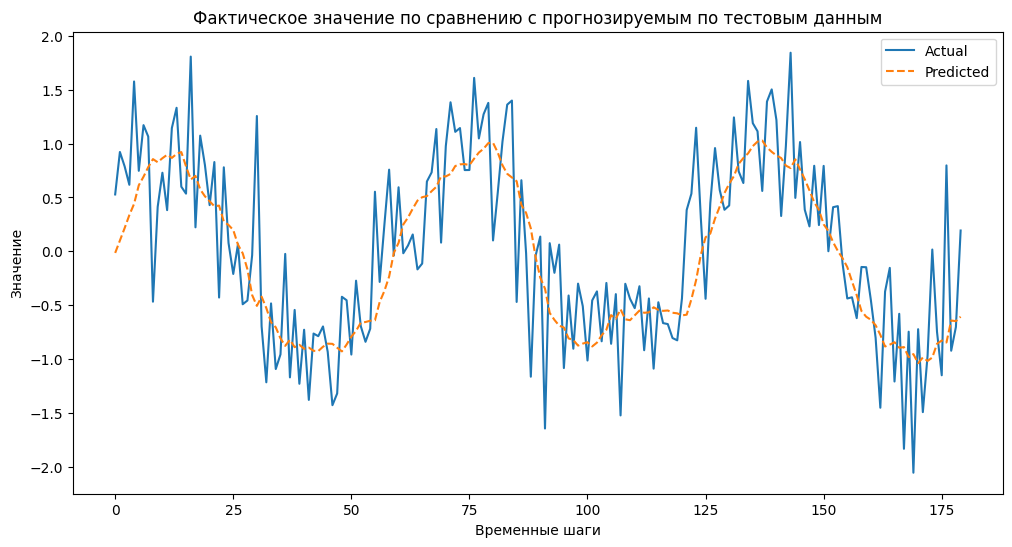

In [120]:
plt.figure(figsize=(12, 6))
plt.plot(actual, label="Actual", linestyle='-')
plt.plot(predictions, label="Predicted", linestyle='--')
plt.legend()
plt.xlabel("Временные шаги")
plt.ylabel("Значение")
plt.title("Фактическое значение по сравнению с прогнозируемым по тестовым данным")
plt.show()

In [115]:
# 3. решите задачу набора данных лекции 7.
# Задание (файл 2)
# Разделить данные на N групп. (возможно, выбрать первые M данных для обучения)
# Реализовать предсказание ARIMA для 2 (тренировочной группы) на основе 1. Рассчитать MSE.
# Исследовать качество работы модели в зависимости от параметров (для групп 1-2).
# (1)Выполнить итеративное предсказание, данные для каждого следующего предсказания обновлять по методу
# "экспоненциальное среднее".
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error


Ошибка MSE для модели ARIMA: 0.271


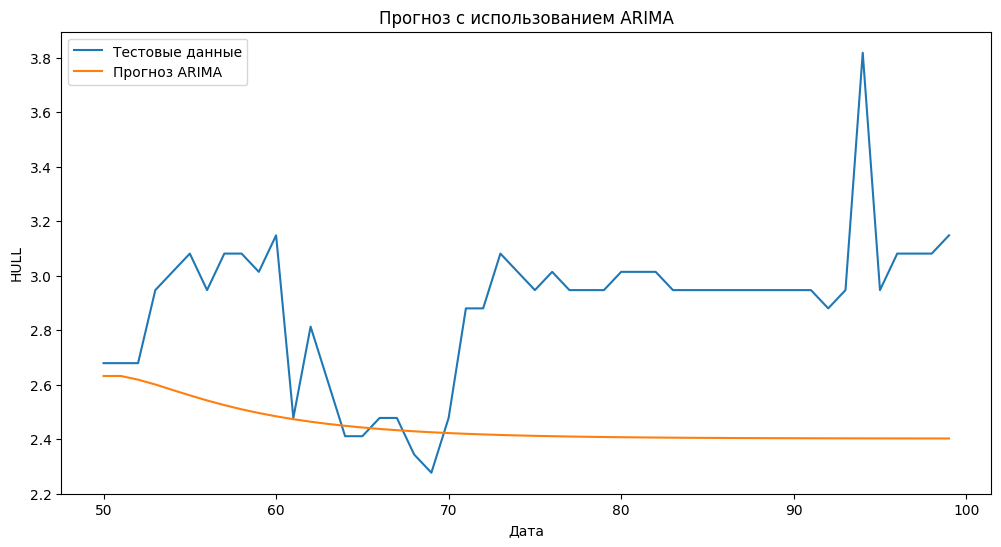

In [116]:
df = pd.read_csv('C:/Users/vadim/Downloads/ETTm1.csv')
x = df.HULL  

M = 50
N = 50  

x_train = x[:M]  
x_test = x[M:M+N] 

model_arima = ARIMA(x_train, order=(3, 0, 0)).fit()
predictions_arima = model_arima.forecast(len(x_test))

mse_arima = mean_squared_error(x_test, predictions_arima)
print(f'Ошибка MSE для модели ARIMA: {mse_arima:.3f}')

plt.figure(figsize=(12, 6))
plt.plot(x_test, label='Тестовые данные')
plt.plot(predictions_arima, label='Прогноз ARIMA')
plt.title('Прогноз с использованием ARIMA')
plt.xlabel('Дата')
plt.ylabel('HULL')
plt.legend()
plt.show()

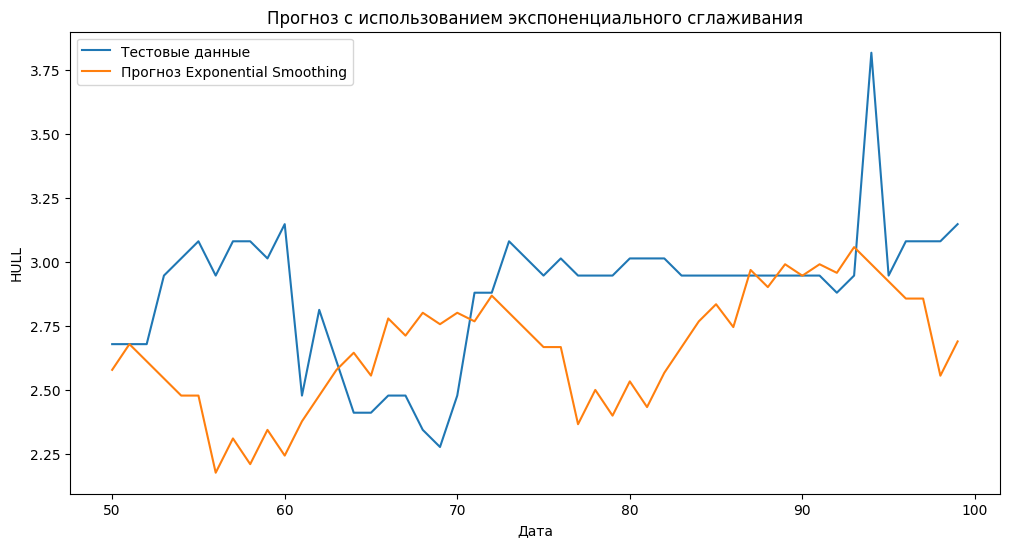

Ошибка MSE для модели Exponential Smoothing: 0.167


In [117]:
# Начальные данные для прогноза
x_train_iter = x[:M]
x_test_iter = x[M:M+N]

# Используем экспоненциальное сглаживание
exp_model = ExponentialSmoothing(x_train_iter, trend='add', seasonal='add', seasonal_periods=21).fit()
exp_predictions = exp_model.forecast(len(x_test_iter))

plt.figure(figsize=(12, 6))
plt.plot(x_test_iter, label='Тестовые данные')
plt.plot(exp_predictions, label='Прогноз Exponential Smoothing')
plt.title('Прогноз с использованием экспоненциального сглаживания')
plt.xlabel('Дата')
plt.ylabel('HULL')
plt.legend()
plt.show()


mse_exp = mean_squared_error(x_test_iter, exp_predictions)
print(f'Ошибка MSE для модели Exponential Smoothing: {mse_exp:.3f}')